In [76]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy
from tqdm.notebook import tqdm
import torch
import math
import torch.distributions as dist

import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy, UnwhitenedVariationalStrategy
# from gpytorch.likelihoods.likelihood import _OneDimensionalLikelihood
# from gpytorch.functions import log_normal_cdf
# from gpytorch.utils.quadrature import GaussHermiteQuadrature1D

from pymc3.gp.util import plot_gp_dist

In [77]:
%config InlineBackend.figure_format = "retina"
sns.set()

In [78]:
# Set seed
np.random.seed(123)

# Generate data

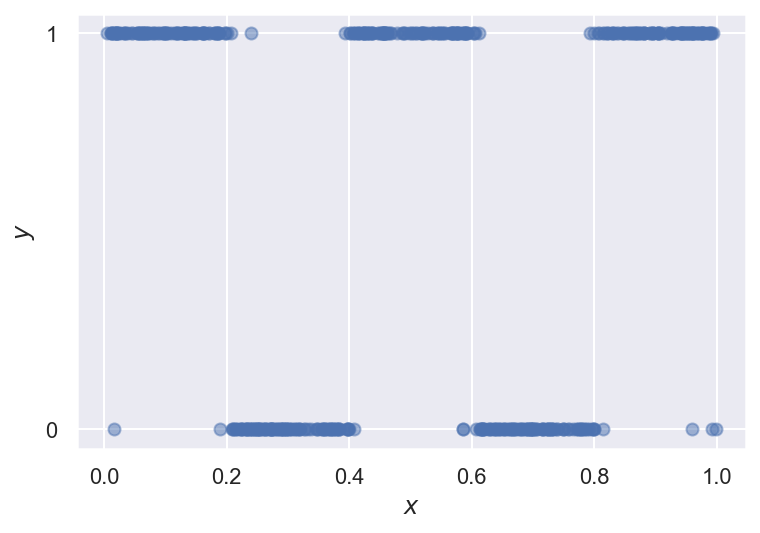

In [79]:
np.random.seed(0)

def true_f(x):
    return np.sin(10*x * np.pi * 0.5) * 10

n = 500
x = np.sort(np.random.uniform(0, 1, n))
f = true_f(x)
y = scipy.stats.bernoulli.rvs(scipy.special.expit(f))

plt.scatter(x, y, alpha=0.5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.yticks([0, 1]);

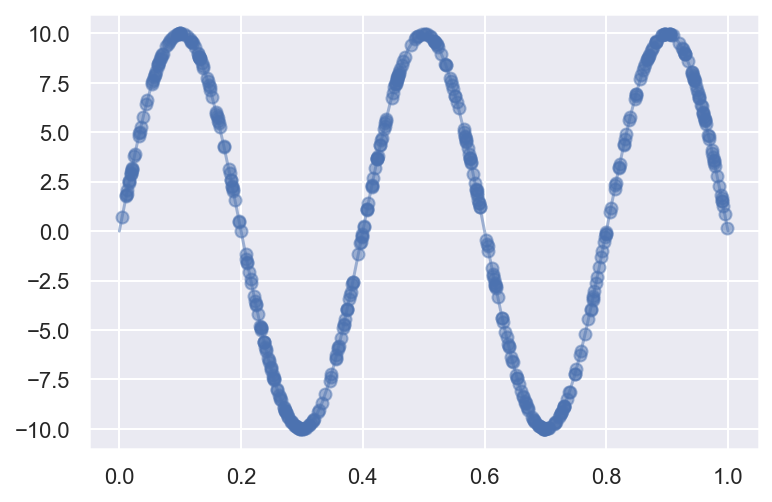

In [80]:
fig, ax = plt.subplots()
x_plot = np.linspace(0, 1, 100)
ax.plot(x_plot, true_f(x_plot), alpha=0.5)
ax.scatter(x, f, alpha=0.5);

In [81]:
train_x = torch.from_numpy(x.astype(np.float32))
train_y = torch.from_numpy(y.astype(np.float32))
print(train_x.dtype)
print(train_y.dtype)

torch.float32
torch.float32


In [82]:
inducing_points = torch.rand(50)

In [83]:
from torch.nn import Module

def _pad_with_singletons(obj, num_singletons_before=0, num_singletons_after=0):
    """
    Pad obj with singleton dimensions on the left and right

    Example:
        >>> x = torch.randn(10, 5)
        >>> _pad_width_singletons(x, 2, 3).shape
        >>> # [1, 1, 10, 5, 1, 1, 1]
    """
    new_shape = [1] * num_singletons_before + list(obj.shape) + [1] * num_singletons_after
    return obj.view(*new_shape)


class GaussHermiteQuadrature1D(Module):
    """
    Implements Gauss-Hermite quadrature for integrating a function with respect to several 1D Gaussian distributions
    in batch mode. Within GPyTorch, this is useful primarily for computing expected log likelihoods for variational
    inference.

    This is implemented as a Module because Gauss-Hermite quadrature has a set of locations and weights that it
    should initialize one time, but that should obey parent calls to .cuda(), .double() etc.
    """

    def __init__(self, num_locs=None):
        super().__init__()
        if num_locs is None:
            """
            The number of samples to draw from a latent GP when computing a likelihood
            This is used in variational inference and training

            (Default: 20)
            """
            num_locs = 20
        
        self.num_locs = num_locs

        locations, weights = self._locs_and_weights(num_locs)

        self.locations = locations
        self.weights = weights

    def _apply(self, fn):
        self.locations = fn(self.locations)
        self.weights = fn(self.weights)
        return super(GaussHermiteQuadrature1D, self)._apply(fn)

    def _locs_and_weights(self, num_locs):
        """
        Get locations and weights for Gauss-Hermite quadrature. Note that this is **not** intended to be used
        externally, because it directly creates tensors with no knowledge of a device or dtype to cast to.

        Instead, create a GaussHermiteQuadrature1D object and get the locations and weights from buffers.
        """
        locations, weights = np.polynomial.hermite.hermgauss(num_locs)
        locations = torch.Tensor(locations)
        weights = torch.Tensor(weights)
        return locations, weights

    def forward(self, func, gaussian_dists):
        """
        Runs Gauss-Hermite quadrature on the callable func, integrating against the Gaussian distributions specified
        by gaussian_dists.

        Args:
            - func (callable): Function to integrate
            - gaussian_dists (Distribution): Either a MultivariateNormal whose covariance is assumed to be diagonal
                or a :obj:`torch.distributions.Normal`.
        Returns:
            - Result of integrating func against each univariate Gaussian in gaussian_dists.
        """
        means = gaussian_dists.mean
        variances = gaussian_dists.variance

        locations = _pad_with_singletons(self.locations, num_singletons_before=0, num_singletons_after=means.dim())

        shifted_locs = torch.sqrt(2.0 * variances) * locations + means
        log_probs = func(shifted_locs)
        weights = _pad_with_singletons(self.weights, num_singletons_before=0, num_singletons_after=log_probs.dim() - 1)

        res = (1 / math.sqrt(math.pi)) * (log_probs * weights)
        res = res.sum(tuple(range(self.locations.dim())))

        return res


In [84]:
a = torch.rand(3)
print(torch.distributions.LogNormal(0, 1).cdf(a))
print(torch.log(torch.distributions.Normal(0, 1).cdf(a)))

tensor([0.1236, 0.4007, 0.2677])
tensor([-0.4726, -0.2464, -0.3499])


In [121]:
def log_normal_cdf(z):
    """
    Computes the element-wise log standard normal CDF of an input tensor x.

    This function should always be preferred over calling normal_cdf and taking the log
    manually, as it is more numerically stable.
    """
    c = torch.tensor(
        [
            0.00048204,
            -0.00142906,
            0.0013200243174,
            0.0009461589032,
            -0.0045563339802,
            0.00556964649138,
            0.00125993961762116,
            -0.01621575378835404,
            0.02629651521057465,
            -0.001829764677455021,
            2 * (1 - math.pi / 3),
            (4 - math.pi) / 3,
            1,
            1,
        ],
        dtype=z.dtype,
        device=z.device,
    )

    r = torch.tensor(
        [
            1.2753666447299659525,
            5.019049726784267463450,
            6.1602098531096305441,
            7.409740605964741794425,
            2.9788656263939928886,
        ],
        dtype=z.dtype,
        device=z.device,
    )

    q = torch.tensor(
        [
            2.260528520767326969592,
            9.3960340162350541504,
            12.048951927855129036034,
            17.081440747466004316,
            9.608965327192787870698,
            3.3690752069827527677,
        ],
        dtype=z.dtype,
        device=z.device,
    )

    log_phi_z = torch.zeros_like(z)

    # Three cases to handle: An entry of z is near zero, an entry of z is small, or an entry of z neither of these.
    z_near_zero = z.pow(2).lt(0.04)
    z_is_small = z.lt(-1)
    z_is_ordinary = ~(z_near_zero | z_is_small)

    # Case 1: Entries of z that are near zero
    if z_near_zero.sum() > 0:
        log_phi_first = -z.masked_select(z_near_zero).div_(math.sqrt(2 * math.pi))
        f = 0
        for c_i in c.tolist():
            f = log_phi_first.mul(c_i + f)

        log_phi_z.masked_scatter_(z_near_zero, f.mul_(-2).sub_(math.log(2)))

    # Case 2: Entries of z that are very small
    if z_is_small.sum() > 0:
        z_where_z_is_small = z.masked_select(z_is_small)
        numerator = torch.tensor(0.5641895835477550741, dtype=z.dtype, device=z.device)
        numerator = numerator.expand_as(z_where_z_is_small)
        denominator = torch.tensor(1.0, dtype=z.dtype, device=z.device)
        denominator = denominator.expand_as(z_where_z_is_small)

        for r_i in r:
            numerator = -z_where_z_is_small.mul(numerator.div(math.sqrt(2))) + r_i

        for q_i in q:
            denominator = -z_where_z_is_small.mul(denominator.div(math.sqrt(2))) + q_i

        e = numerator.div(denominator)
        log_phi_z.masked_scatter_(z_is_small, torch.log(e / 2) - z_where_z_is_small.pow(2).div_(2))

        # ctx.denominator = denominator
        # ctx.numerator = numerator

    log_phi_z.masked_scatter_(z_is_ordinary, torch.log(dist.Normal(0.0, 1.0).cdf(z.masked_select(z_is_ordinary))))

    # ctx.save_for_backward(z, log_phi_z)
    return log_phi_z
    # return torch.log(torch.distributions.Normal(0, 1).cdf(x)+1e-07) # LogNormalCDF().apply(x)

class BernoulliLikelihood():
    
    r"""
    A specific case of :obj:`~gpytorch.likelihoods.Likelihood` when the GP represents a one-dimensional
    output. (I.e. for a specific :math:`\mathbf x`, :math:`f(\mathbf x) \in \mathbb{R}`.)

    Inheriting from this likelihood reduces the variance when computing approximate GP objective functions
    by using 1D Gauss-Hermite quadrature.
    """
        
    r"""
    Implements the Bernoulli likelihood used for GP classification, using
    Probit regression (i.e., the latent function is warped to be in [0,1]
    using the standard Normal CDF :math:`\Phi(x)`). Given the identity
    :math:`\Phi(-x) = 1-\Phi(x)`, we can write the likelihood compactly as:
    .. math::
        \begin{equation*}
            p(Y=y|f)=\Phi(yf)
        \end{equation*}
        
    """
    
    def __init__(self):
        self.quadrature = GaussHermiteQuadrature1D()

    def forward(self, function_samples, **kwargs):
        raise NotImplementedError

    def log_marginal(self,  *args, **kwargs):
        raise NotImplementedError

    def marginal(self, function_dist, **kwargs):
        raise NotImplementedError

    def expected_log_prob(self, observations, function_dist, n_sample=40, *params, **kwargs):
        
        # Rescale 0,1 => -1,1
        # observations = observations.mul(2).sub(1)
        # log_normal_cdf(function_samples.mul(observations))
        
        def log_prob_lambda(function_samples): 
            # print(function_samples.shape)  20 x Nobs
            return dist.Bernoulli(logits=function_samples).log_prob(observations)
        
        log_prob = self.quadrature(log_prob_lambda, function_dist)
        
        return log_prob

In [122]:
class GPClassificationModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
        self.quadrature = GaussHermiteQuadrature1D()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


# Initialize model and likelihood
model = GPClassificationModel(inducing_points=inducing_points)
likelihood = BernoulliLikelihood()

In [123]:
training_iter = 1000


# Find optimal model hyperparameters
model.train()
# likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the number of training datapoints
mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())


iterator = tqdm(range(training_iter))

for i in iterator:
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    
    optimizer.step()
    
    iterator.set_postfix(loss=loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

In [124]:
test_x = torch.linspace(0, 1, 101)
f_preds = model(test_x)

In [125]:
pred = f_preds.sample(torch.Size((1000,))).numpy()

In [126]:
pred.shape

(1000, 101)

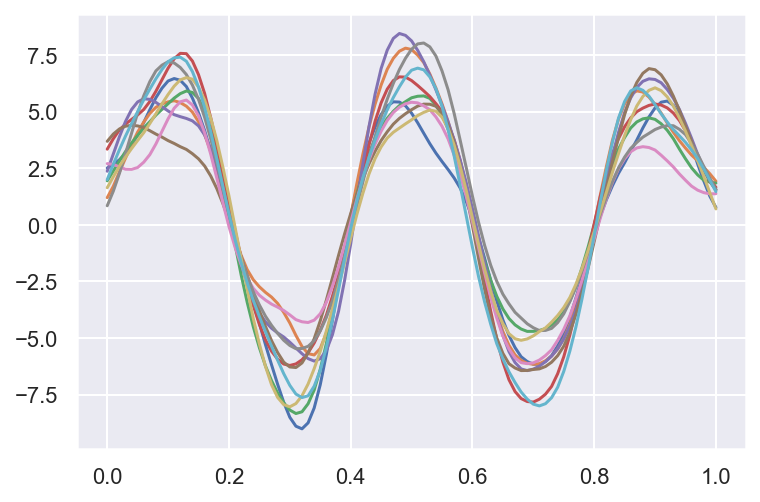

In [127]:
fig, ax = plt.subplots()
for i in range(10):
    ax.plot(test_x, pred[i])

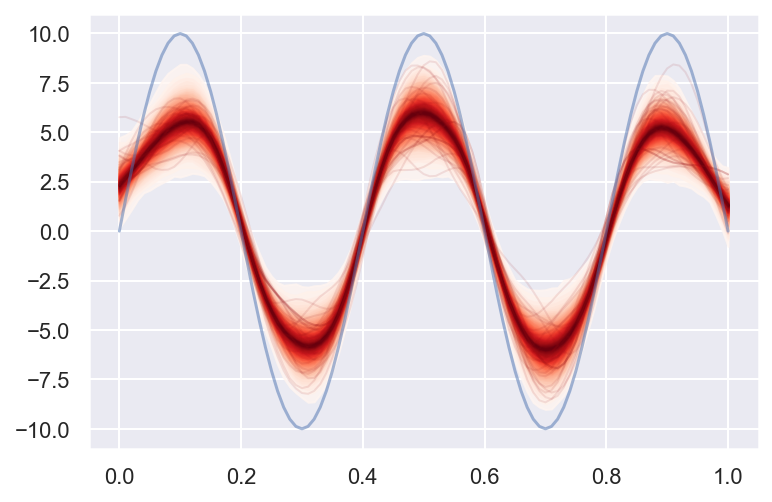

In [128]:
fig, ax = plt.subplots()
plot_gp_dist(ax, pred, test_x)
ax.plot(test_x, true_f(test_x), alpha=0.5)